In [2]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

# Data Import

In [4]:
data = pandas.read_csv('./dataset/Fraud_Data.csv')

In [5]:
ip_addresses = pandas.read_csv('./dataset/IpAddress_to_Country.csv')

In [5]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
data.shape

(151112, 11)

In [7]:
ip_addresses.shape

(138846, 3)

In [8]:
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
data_country = []

In [7]:
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ip_addresses[(ip_addresses['lower_bound_ip_address'] <= ip_address) &
                          (ip_addresses['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        data_country.append(tmp['country'].values[0])
    else:
        data_country.append('NA')

In [31]:
print(data_country[0:3])

['Japan', 'United States', 'United States']


In [8]:
data['country'] = data_country

In [9]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [55]:
data.user_id.nunique()

151112

In [37]:
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

Feature Engineering
Time difference between sign-up time and purchase time
If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
Usual week of the year and day of the week from time variables

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

# Feature Engineering

In [12]:
#make them dates
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])
#and take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

In [13]:
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

In [16]:
# the less visit from a country, the more suspicious
data['country_count'] =  data.groupby('country')['country'].transform('count')

In [18]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)


In [22]:
data['signup_hour'] = data['signup_time'].apply(lambda x: x.hour)

In [25]:
# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)
data['purchase_hour'] = data['purchase_time'].apply(lambda x: x.hour)

In [26]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_signup_diff,device_id_count,ip_address_count,country_count,signup_day,signup_week,signup_hour,purchase_day,purchase_week,purchase_hour
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,4506682.0,1,1,7306,1,9,22,5,16,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,17944.0,1,1,58049,6,23,20,0,24,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1.0,12,12,58049,3,1,18,3,1,18
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,492085.0,1,1,21966,1,18,21,0,19,13
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,4361461.0,1,1,58049,1,30,7,2,37,18


In [24]:
data.signup_hour.nunique()

24

In [15]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,ip_address_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


In [14]:
data.to_csv('./fraud_data.csv')

In [27]:
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)

In [28]:
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[15:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)

In [29]:
data_rf.groupby('country').size().sort_values(ascending=False)[15:].index

Index(['India'], dtype='object', name='country')

In [30]:
data_rf.country.nunique()

16

# Model Building

In [31]:
#make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True) 
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9568146952362808 
 OOB Confusion Matrix 
        0     1
0  90435    10
1   4297  4991


In [32]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.956110473150509 
 Test Set Confusion Matrix 
        0     1
0  46515     1
1   2254  2609


The confusion matrix looks good. We are not overfitting given that OOB and test results are very similar. Class 0 error is almost zero, and we are doing surprisignly well also with regards to class 1 error, which is pretty rare.


However, since the challenge asks about false positives and false negatives, this usually implies building the ROC and look for possible cut-off points. And in general, especially when dealing with fraud, you should always do the cut-off analysis. There is no reason why the default 0.5 value has to be the best one. 

In [33]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


In [34]:
print(pred)

[0 0 1 ... 0 0 1]


In [35]:
print(pred_prob)

[0.04 0.06 1.   ... 0.02 0.04 1.  ]


Cool. So they are the same! However, is really 0.5 the best possible cut-off? It really depends on what we are optimizing for (accuracy? true positive? true negative? etc.) 

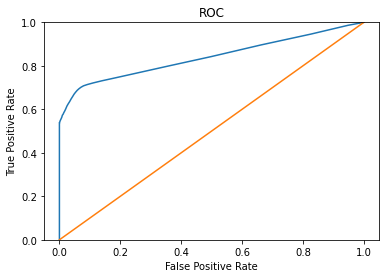

In [36]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate near 0.6 and false positive rate basically zero (this was similar to the default random forest output). However, if we care about maximizing true positive rate, we will have to significantly decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up). 


If we want to be a bit more accurate, we can use the approach of maximizing true positive rate - false positive rate, this is the same as maximizing (1-class1_error) - class0_error as we saw in the unbalanced data section. 

In [37]:
#we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                               'class0_error':pandas.Series(fpr),
                               'class1_error': 1 - pandas.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
42    0.12      0.070879      0.298375       0.630746


In [40]:
error_cutoff.sort_values('optimal_value', ascending=False).head()

,cutoff,class0_error,class1_error,optimal_value
42,0.12,0.070879,0.298375,0.630746
41,0.13,0.064365,0.305161,0.630474
40,0.14,0.058668,0.312359,0.628973
43,0.11,0.079242,0.291795,0.628963
39,0.15,0.053293,0.320995,0.625711


The best value is in the area near ~65% true positive rate (specifically 1-0.32 = 0.68) and very low false positive rate (~7%). You can find the corresponding point on the ROC curve. 

The last question is very important: 


Let’s say we now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would we use it? That is, what kind of different user experiences would we build based on the model output? 

we now have a model that assigns to each user a probability of committing a fraud. And, despite our model doing pretty well, no model is perfect. So we will have some misclassifications. It is crucial now to think about building a product that minimizes the impact (aka cost) of those misclassifications. A very commonly used approach is to think about creating different experiences based on the model score. For instance:


If predicted fraud probability < X, the user has the normal experience (the high majority of users should fall here)


If X <= predicted fraud probability < Z (so the user is at risk, but not too much), we can create an additional verification step, like phone number verifications via a code sent by SMS or asking to log in via social network accounts


If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud),we can tell the user his activity has been put on hold, send this user info to someone who reviews it manually, and finally either block the user or decide it is not a fraud so the session is resumed


This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives). 


A data product doesn’t mean just putting a model into production, it means buiding a product based on a model output.